# Análisis Exploratorio: San Francisco Bay Bike Rental

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trip_meta = pd.read_csv('data/trip.csv')
weather_meta = pd.read_csv('data/weather.csv')

In [3]:
pd.options.mode.chained_assignment = None

### Convierto las fechas a datetime

In [4]:
trip_meta['start_date'] = pd.to_datetime(trip_meta['start_date'])

In [5]:
trip_meta['end_date'] = pd.to_datetime(trip_meta['end_date'])

In [6]:
import datetime
from datetime import date,time

In [7]:
#Saco los horarios de las fechas para analizar primero los viajes que son realizados durante el mismo dia
trip_meta['start_date2'] = trip_meta.start_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))
trip_meta['end_date2'] = trip_meta.end_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))

In [8]:
trip_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 13 columns):
id                    669959 non-null int64
duration              669959 non-null int64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
start_date2           669959 non-null datetime64[ns]
end_date2             669959 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(5), object(4)
memory usage: 66.4+ MB


In [9]:
same_day = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['id','duration','start_date2','end_date2','start_station_name','start_station_id','end_station_name','end_station_id']]

In [10]:
same_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667860 entries, 0 to 669958
Data columns (total 8 columns):
id                    667860 non-null int64
duration              667860 non-null int64
start_date2           667860 non-null datetime64[ns]
end_date2             667860 non-null datetime64[ns]
start_station_name    667860 non-null object
start_station_id      667860 non-null int64
end_station_name      667860 non-null object
end_station_id        667860 non-null int64
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 45.9+ MB


### Son 2099 los viajes que duran mas de 1 dia

In [11]:
print len(trip_meta) - len(same_day)

2099


In [12]:
same_day.describe()

,id,duration,start_station_id,end_station_id
count,667860.000000,667860.000000,667860.000000,667860.00000
mean,460563.297664,896.212209,57.877699,57.85896
std,264565.577399,2190.634652,17.088461,17.17720
min,4069.000000,60.000000,2.000000,2.00000
25%,231317.750000,344.000000,50.000000,50.00000
50%,459550.000000,516.000000,62.000000,62.00000
75%,692844.250000,753.000000,70.000000,70.00000
max,913460.000000,83409.000000,84.000000,84.00000


### Filtro los viajes que duran menos de 5 minutos

In [13]:
trips_longer = same_day.loc[same_day.duration > 300,:]

In [14]:
trips_longer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542405 entries, 100 to 669958
Data columns (total 8 columns):
id                    542405 non-null int64
duration              542405 non-null int64
start_date2           542405 non-null datetime64[ns]
end_date2             542405 non-null datetime64[ns]
start_station_name    542405 non-null object
start_station_id      542405 non-null int64
end_station_name      542405 non-null object
end_station_id        542405 non-null int64
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 37.2+ MB


In [15]:
trips_longer.duration = trips_longer.duration.apply(lambda x: x/60.0)

### Son 125455 los viajes que duran menos de 5 min

In [16]:
print len(same_day) - len(trips_longer)

125455


### Convierto a datetime la fecha en el DF weather

In [17]:
weather_meta['date'] = pd.to_datetime(weather_meta['date'])

# Analizo la cantidad de viajes segun la temperatura

In [18]:
temperatures = weather_meta[['date','max_temperature_f','mean_temperature_f','min_temperature_f']]

In [19]:
# Paso la temperatura a Celsius
temperatures.max_temperature_f = temperatures.max_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.mean_temperature_f = temperatures.mean_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.min_temperature_f = temperatures.min_temperature_f.apply(lambda x: (x-32) / 1.8)

In [20]:
temperatures.rename(
    columns={'max_temperature_f':'max_temperature_c','mean_temperature_f':'mean_temperature_c','min_temperature_f':'min_temperature_c'},inplace=True)

In [21]:
temperatures_avg = temperatures.groupby('date').mean()
temperatures_avg = pd.DataFrame(temperatures_avg.to_records())

In [22]:
final = trips_longer[['id', 'duration', 'start_date2', 'start_station_name','end_station_name']]
final.rename(columns={'start_date2':'date','duration':'duration(min)'},inplace=True)

In [23]:
date_duration = final.loc[:,['duration(min)','date']].groupby('date').agg([np.size])
date_duration = pd.DataFrame(date_duration.to_records())
date_duration.columns=['date','# trips']

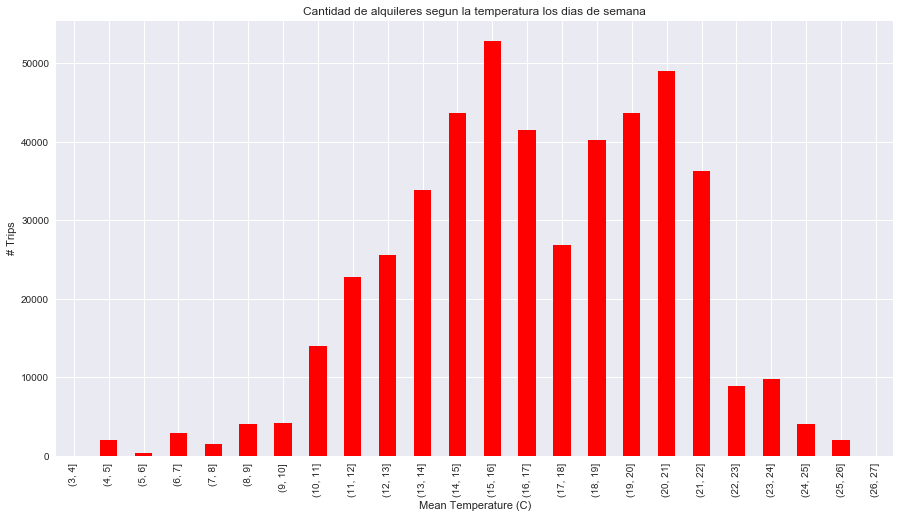

In [24]:
duration_temperature = pd.merge(date_duration,temperatures_avg,how='inner',on='date')
duration_temperature['weekday'] = duration_temperature.date.apply(lambda x: x.weekday())
duration_temperature_weekdays = duration_temperature\
                        .loc[(duration_temperature.weekday != 5) & (duration_temperature.weekday != 6),:]

duration_temperature_weekdays = duration_temperature_weekdays\
                        [['# trips','date','max_temperature_c','mean_temperature_c','min_temperature_c']]
    
trips_temperature = duration_temperature_weekdays.\
                groupby(pd.cut(duration_temperature_weekdays['mean_temperature_c'], np.arange(3,28))).sum()

f = plt.figure()
ax = trips_temperature['# trips'].plot.bar(figsize=(15,8),colormap='autumn',layout=('# trips','Mean Temperature (C)'), ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Mean Temperature (C)');
plt.title('Cantidad de alquileres segun la temperatura los dias de semana')
plt.show()

# ---------------------------------------------------------------------------------------------------------

# Alquiler de bicicletas por hora

In [25]:
trip_meta['hour'] = trip_meta.start_date.apply(lambda x: x.hour)

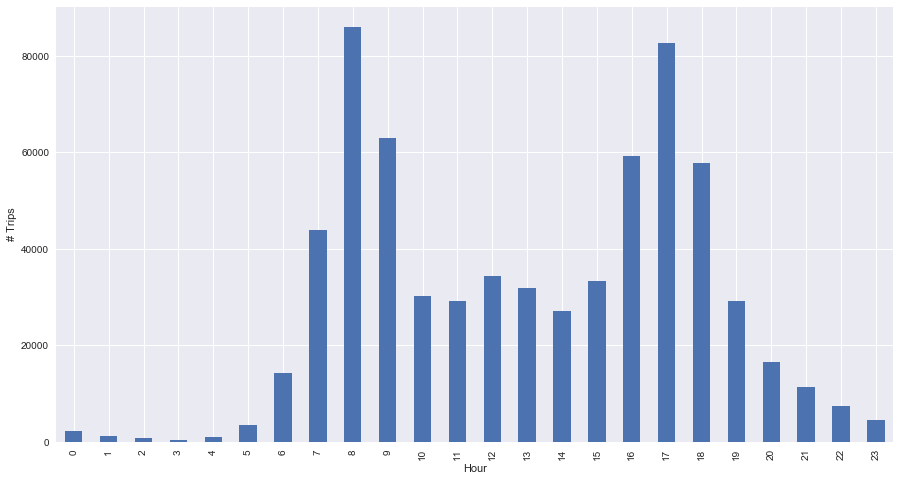

In [26]:
ax = trip_meta.groupby('hour').size().plot(kind='bar',figsize=(15,8))
ax.set_ylabel('# Trips')
ax.set_xlabel('Hour')

# ------------------------------------------------------------------------------------------------------

# Alquiler de bicicletas segun la lluvia, los dias de semana

In [27]:
precipitation = weather_meta[['date','precipitation_inches']]

In [28]:
precipitation.columns = ['date','inches']

In [29]:
precipitation = precipitation.loc[precipitation.inches != 'T',:]
precipitation.inches = pd.to_numeric(precipitation.inches)

In [30]:
precipitation = precipitation.groupby('date').mean()
precipitation = pd.DataFrame(precipitation.to_records())

In [31]:
precipitation_trips = pd.merge(date_duration,precipitation,how='inner',on='date')

In [32]:
precipitation_trips = precipitation_trips[['# trips','date','inches']]

In [33]:
precipitation_trips['weekday'] = precipitation_trips.date.apply(lambda x: x.weekday())
precipitation_trips = precipitation_trips.loc[(precipitation_trips.weekday != 5) & (precipitation_trips.weekday != 6),:]

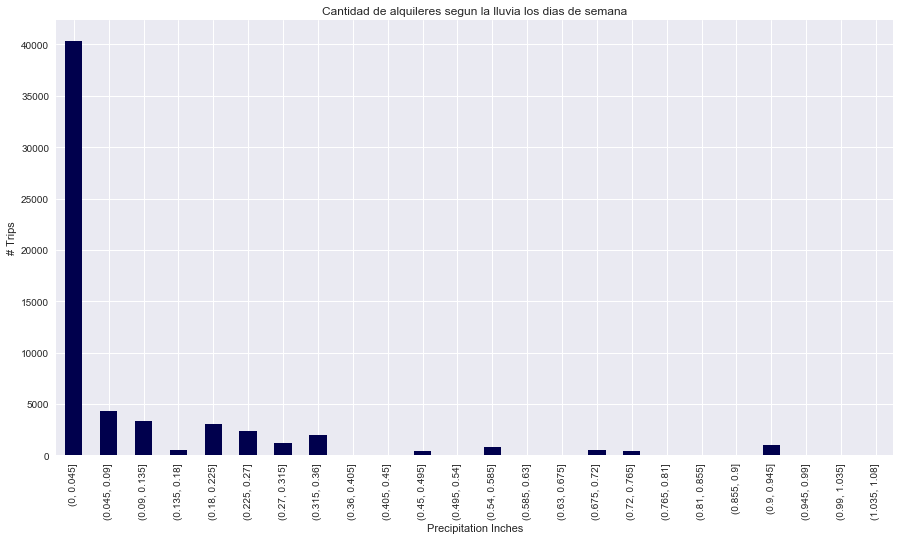

In [34]:
precipitation_trips_plot = precipitation_trips.\
                groupby(pd.cut(precipitation_trips['inches'], np.arange(0, 1.1, 0.045))).sum()

f = plt.figure()
ax = precipitation_trips_plot['# trips'].plot.bar(figsize=(15,8),colormap='seismic',ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Precipitation Inches');
plt.title('Cantidad de alquileres segun la lluvia los dias de semana')
plt.show()

# Cantidad de alquileres por dia y la duracion promedio de los mismos.

In [35]:
dif_day_trips = final[['duration(min)','date']]
dif_day_trips['weekday'] = dif_day_trips.date.apply(lambda x: x.weekday())

In [36]:
def dia(x):
    if x==0:
        return 'Lunes'
    if x==1:
        return 'Martes'
    if x==2:
        return 'Miercoles'
    if x==3:
        return 'Jueves'
    if x==4:
        return 'Viernes'
    if x==5:
        return 'Sabado'
    if x==6:
        return 'Domingo'

In [37]:
dif_day_trips['weekday'] = dif_day_trips['weekday'].apply(dia)

In [38]:
dif_day_trips = dif_day_trips[['duration(min)','weekday']]

In [39]:
trips_by_day = dif_day_trips.groupby('weekday').agg([np.mean,np.size])
trips_by_day

duration(min)         
                   mean     size
weekday                         
Domingo       36.838362  33548.0
Jueves        14.532981  95503.0
Lunes         14.507142  92669.0
Martes        14.021545  97411.0
Miercoles     14.322358  96160.0
Sabado        34.903722  38940.0
Viernes       16.256842  88174.0

In [40]:
dif_day_trips_cant = pd.DataFrame(trips_by_day.to_records())
dif_day_trips_cant.columns = ['weekday','avg trip','trips']
dif_day_trips_avg = dif_day_trips_cant[['weekday','avg trip']]
dif_day_trips_cant = dif_day_trips_cant[['weekday','trips']]

## Cantidad de alquileres por dia

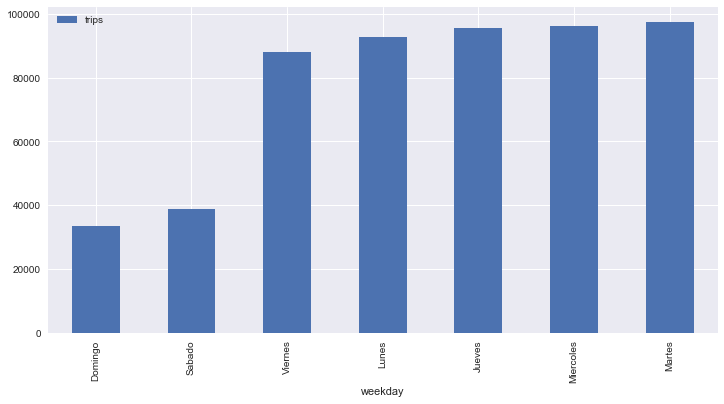

In [41]:
dif_day_trips_cant.sort_values('trips').plot(x='weekday',y='trips',kind='bar',figsize=(12,6))

## Duracion promedio de los alquileres por dia

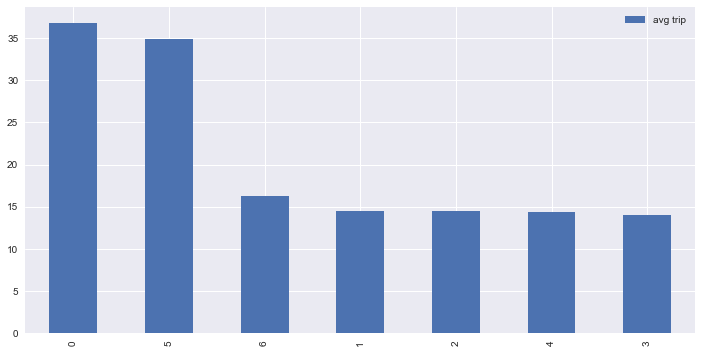

In [52]:
dif_day_trips_avg.sort_values('avg trip',ascending=False).plot(kind='bar',figsize=(12,6))

# Estaciones más populares

In [43]:
station_stats = pd.concat([trip_meta['start_station_name'], trip_meta['end_station_name']])
station_stats.head()

0    South Van Ness at Market
1          San Jose City Hall
2     Mountain View City Hall
3          San Jose City Hall
4    South Van Ness at Market
dtype: object

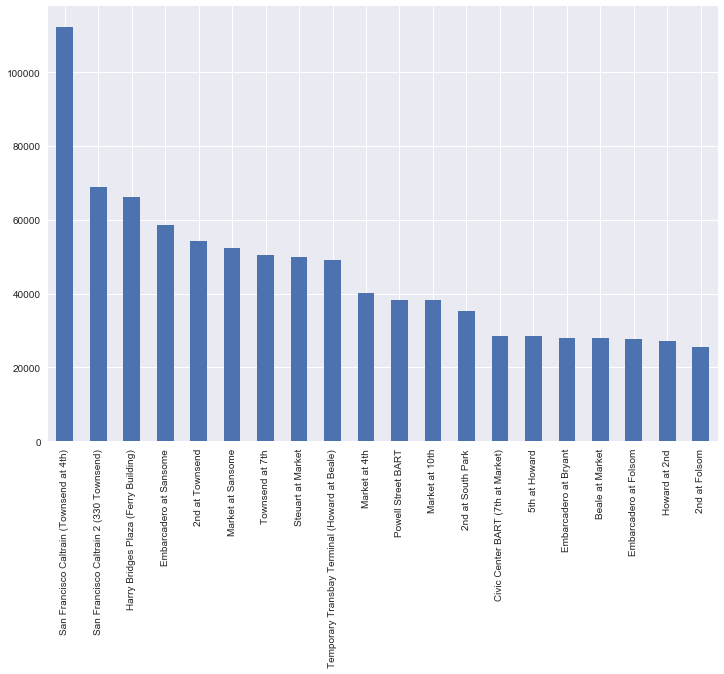

In [44]:
# TOP 20 Estaciones mas populares
station_stats_plot = station_stats.value_counts().head(20).plot(kind='bar',rot=90,figsize=(12,8));
station_stats_plot

## Estaciones más populares por día

In [45]:
popular_stations = trip_meta[['start_date','start_station_name','duration']]

In [46]:
# Filtro los viajes que duran menos de 5 minutos
popular_stations = popular_stations.loc[popular_stations.duration > 300,:]
popular_stations.head()

,start_date,start_station_name,duration
100,2013-08-29 17:22:00,Civic Center BART (7th at Market),305
101,2013-08-29 12:12:00,University and Emerson,307
102,2013-08-29 11:53:00,San Francisco City Hall,309
103,2013-08-29 11:58:00,Powell Street BART,309
104,2013-08-29 18:09:00,2nd at Townsend,309


In [47]:
popular_stations = popular_stations[['start_date','start_station_name']]
popular_stations.rename(columns={'start_date':'date','start_station_name':'station'},inplace=True)

In [48]:
popular_stations['weekday'] = popular_stations.date.apply(lambda x: x.weekday())

In [49]:
popular_stations['weekday'] = popular_stations['weekday'].apply(dia)
popular_stations = popular_stations[['station','weekday']]

In [55]:
print popular_stations.groupby('weekday')

In [56]:
#---------------------------------------------------------------------------------------------------------__

# Viajes segun el tipo de subscripcion

In [69]:
subscription_trips = trip_meta.loc[:,['duration','subscription_type']]
subscription_trips['duration'] = subscription_trips['duration'].apply(lambda x: x/60.0)
subscription_trips = subscription_trips.groupby('subscription_type').agg([np.mean,np.size])
subscription_trips

duration          
                        mean      size
subscription_type                     
Customer           65.862689  103213.0
Subscriber          9.834148  566746.0

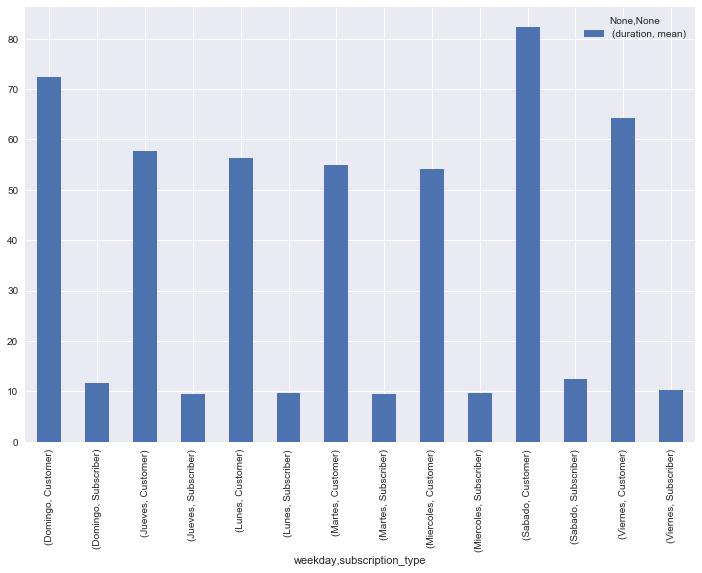

In [84]:
subscription_trips2 = trip_meta.loc[:,['duration','subscription_type','start_date2']]
subscription_trips2['weekday'] = subscription_trips2['start_date2'].apply(lambda x: x.weekday())
subscription_trips2['weekday'] = subscription_trips2['weekday'].apply(dia)
subscription_trips2['duration'] = subscription_trips2['duration'].apply(lambda x: x/60.0)
subscription_trips2.loc[:,['duration','subscription_type','weekday']].groupby(['weekday','subscription_type']).agg([np.mean]).plot.bar(figsize=(12,8))

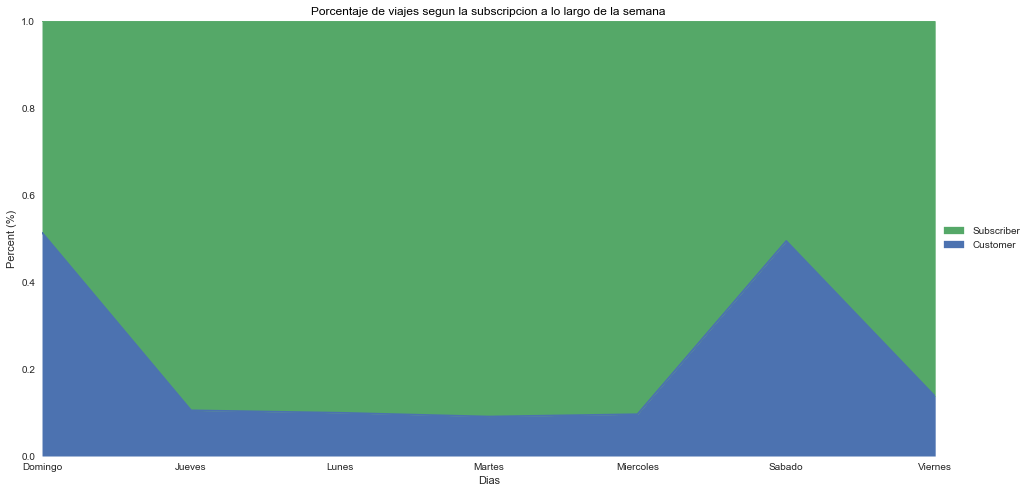

In [105]:
subscription_trips3 = trip_meta.loc[:,['duration','subscription_type','start_date2']]
subscription_trips3['weekday'] = subscription_trips3['start_date2'].apply(lambda x: x.weekday())
subscription_trips3['weekday'] = subscription_trips3['weekday'].apply(dia)
subscription_trips3['duration'] = subscription_trips3['duration'].apply(lambda x: x/60.0)
subscription_trips3 = subscription_trips3.loc[:,['duration','subscription_type','weekday']].groupby(['weekday','subscription_type']).agg([np.size])
subscription_trips3 = pd.DataFrame(subscription_trips3.to_records())
subscription_trips3.columns = ['weekday','subscription_type','trips']
subscription_trips3 = pd.pivot_table(subscription_trips3,values='trips',columns='subscription_type',index='weekday')
subscription_trips3 = subscription_trips3.divide(subscription_trips3.sum(axis=1),axis=0)

f = plt.figure()
plt.title('Porcentaje de viajes segun la subscripcion a lo largo de la semana', color='black')
ax = subscription_trips3.plot(kind='area', stacked=True,figsize=(16,8),ax=f.gca())
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel('Percent (%)');
ax.set_xlabel('Dias');
ax.set_ylim(0,1)
plt.legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()